In [1]:
import netCDF4 as nc
from netCDF4 import num2date,date2index
import datetime
import csv
import numpy as np
import pandas as pd
import xarray as xr
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Dense
from keras.models import Model
from sklearn.preprocessing import normalize
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression
from tensorflow.keras.initializers import glorot_uniform
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

2024-01-08 11:53:31.928038: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-08 11:53:31.929351: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-08 11:53:31.948124: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-08 11:53:31.948145: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-08 11:53:31.948761: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [2]:
data = nc.Dataset('GPH200.nc')

In [3]:
data

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    CDI: Climate Data Interface version 1.9.10 (https://mpimet.mpg.de/cdi)
    Conventions: COARDS
    description:  Data from NCEP initialized reanalysis (4x/day).  These are interpolated to pressure surfaces from model (sigma) surfaces.
    platform: Model
    NCO: 20121012
    title: monthly mean hgt from the NCEP Reanalysis
    dataset_title: NCEP-NCAR Reanalysis 1
    References: http://www.psl.noaa.gov/data/gridded/data.ncep.reanalysis.derived.html
    CDO: Climate Data Operators version 1.9.10 (https://mpimet.mpg.de/cdo)
    history: 12-Dec-2023 06:00:45 Subset NOAA/PSL  
    dimensions(sizes): time(708), lon(144), lat(73), level(1)
    variables(dimensions): float64 time(time), float32 lon(lon), float32 lat(lat), float32 level(level), float32 hgt(time, level, lat, lon)
    groups: 

In [4]:
air = data.variables['hgt']
print(air)

<class 'netCDF4._netCDF4.Variable'>
float32 hgt(time, level, lat, lon)
    long_name: Monthly mean geopotential height
    units: m
    _FillValue: -9.96921e+36
    missing_value: -9.96921e+36
    precision: 0
    least_significant_digit: 0
    GRIB_id: 7
    GRIB_name: HGT
    var_desc: Geopotential height
    level_desc: Pressure Levels
    statistic: Mean
    parent_stat: Other
    dataset: NCEP Reanalysis Derived Products
    actual_range: [ -354.45834 32321.098  ]
unlimited dimensions: time
current shape = (708, 1, 73, 144)
filling off


In [5]:
latitude = data.variables['lat']
print(latitude)

<class 'netCDF4._netCDF4.Variable'>
float32 lat(lat)
    standard_name: latitude
    long_name: Latitude
    units: degrees_north
    axis: Y
    actual_range: [ 90. -90.]
unlimited dimensions: 
current shape = (73,)
filling off


In [6]:
latitude[:].shape

(73,)

In [7]:
longitude = data.variables['lon']
print(longitude)

<class 'netCDF4._netCDF4.Variable'>
float32 lon(lon)
    standard_name: longitude
    long_name: Longitude
    units: degrees_east
    axis: X
    actual_range: [  0.  357.5]
unlimited dimensions: 
current shape = (144,)
filling off


In [8]:
longitude[:]

masked_array(data=[  0. ,   2.5,   5. ,   7.5,  10. ,  12.5,  15. ,  17.5,
                    20. ,  22.5,  25. ,  27.5,  30. ,  32.5,  35. ,  37.5,
                    40. ,  42.5,  45. ,  47.5,  50. ,  52.5,  55. ,  57.5,
                    60. ,  62.5,  65. ,  67.5,  70. ,  72.5,  75. ,  77.5,
                    80. ,  82.5,  85. ,  87.5,  90. ,  92.5,  95. ,  97.5,
                   100. , 102.5, 105. , 107.5, 110. , 112.5, 115. , 117.5,
                   120. , 122.5, 125. , 127.5, 130. , 132.5, 135. , 137.5,
                   140. , 142.5, 145. , 147.5, 150. , 152.5, 155. , 157.5,
                   160. , 162.5, 165. , 167.5, 170. , 172.5, 175. , 177.5,
                   180. , 182.5, 185. , 187.5, 190. , 192.5, 195. , 197.5,
                   200. , 202.5, 205. , 207.5, 210. , 212.5, 215. , 217.5,
                   220. , 222.5, 225. , 227.5, 230. , 232.5, 235. , 237.5,
                   240. , 242.5, 245. , 247.5, 250. , 252.5, 255. , 257.5,
                   260. ,

In [9]:
time = data.variables['time']
time_ = time[:]
time_units = time.units
time_calendar = time.calendar
time_dates = num2date(time_, units=time_units, calendar=time_calendar)
start_date = datetime.datetime(1958, 1, 1)
start_index = date2index(start_date, time, select='nearest')
air_subset = data['hgt'][start_index:, :, :]

In [10]:
data_ = np.array(air_subset)
data_[data_ == -9.96921e+36] = 0

In [11]:
for date in time_dates:
    print(date)

1958-01-01 00:00:00
1958-02-01 00:00:00
1958-03-01 00:00:00
1958-04-01 00:00:00
1958-05-01 00:00:00
1958-06-01 00:00:00
1958-07-01 00:00:00
1958-08-01 00:00:00
1958-09-01 00:00:00
1958-10-01 00:00:00
1958-11-01 00:00:00
1958-12-01 00:00:00
1959-01-01 00:00:00
1959-02-01 00:00:00
1959-03-01 00:00:00
1959-04-01 00:00:00
1959-05-01 00:00:00
1959-06-01 00:00:00
1959-07-01 00:00:00
1959-08-01 00:00:00
1959-09-01 00:00:00
1959-10-01 00:00:00
1959-11-01 00:00:00
1959-12-01 00:00:00
1960-01-01 00:00:00
1960-02-01 00:00:00
1960-03-01 00:00:00
1960-04-01 00:00:00
1960-05-01 00:00:00
1960-06-01 00:00:00
1960-07-01 00:00:00
1960-08-01 00:00:00
1960-09-01 00:00:00
1960-10-01 00:00:00
1960-11-01 00:00:00
1960-12-01 00:00:00
1961-01-01 00:00:00
1961-02-01 00:00:00
1961-03-01 00:00:00
1961-04-01 00:00:00
1961-05-01 00:00:00
1961-06-01 00:00:00
1961-07-01 00:00:00
1961-08-01 00:00:00
1961-09-01 00:00:00
1961-10-01 00:00:00
1961-11-01 00:00:00
1961-12-01 00:00:00
1962-01-01 00:00:00
1962-02-01 00:00:00


In [12]:
data_

array([[[[10959.064 , 10959.064 , 10959.064 , ..., 10959.064 ,
          10959.064 , 10959.064 ],
         [10961.483 , 10961.258 , 10960.807 , ..., 10962.387 ,
          10962.    , 10961.71  ],
         [10968.032 , 10967.807 , 10967.451 , ..., 10968.774 ,
          10968.613 , 10968.29  ],
         ...,
         [11284.129 , 11285.903 , 11287.613 , ..., 11278.419 ,
          11280.451 , 11282.258 ],
         [11276.451 , 11277.097 , 11277.71  , ..., 11274.678 ,
          11275.258 , 11275.903 ],
         [11269.29  , 11269.29  , 11269.29  , ..., 11269.29  ,
          11269.29  , 11269.29  ]]],


       [[[11082.179 , 11082.179 , 11082.179 , ..., 11082.179 ,
          11082.179 , 11082.179 ],
         [11072.857 , 11072.321 , 11071.429 , ..., 11075.25  ,
          11074.357 , 11073.571 ],
         [11072.893 , 11071.643 , 11070.214 , ..., 11076.821 ,
          11075.464 , 11074.214 ],
         ...,
         [11154.643 , 11152.071 , 11149.607 , ..., 11163.25  ,
          11160.214 , 1

In [13]:
np.max(data_)

12631.1045

In [14]:
np.min(data_)

10306.097

In [15]:
data_.shape

(708, 1, 73, 144)

In [16]:
len(data_)

708

In [17]:
num_years = data_.shape[0] // 12
num_months = data_.shape[0] // num_years

In [18]:
num_years

59

In [19]:
num_months

12

In [20]:
data_reshaped = np.reshape(data_, (len(data_) // 12, 12, data_.shape[2],data_.shape[3]))

In [21]:
lat_indices = []
for start_value in np.arange(90, -90, -10):  # Changed step to -10 for descending order
    end_value = start_value - 10  # Adjusted end_value calculation

    # Get indices within the range
    range_indices = np.where((latitude <= start_value) & (latitude > end_value))[0]

    if len(range_indices) > 0:  # Check if any values are within the range
        # Get indices of largest and smallest values
        min_index = range_indices[np.argmax(latitude[range_indices])]
        max_index = range_indices[np.argmin(latitude[range_indices])]
        
        lat_indices.append(min_index)
        lat_indices.append(max_index)

        print(f"Range {start_value} to {end_value}: Min index = {min_index}, Max index = {max_index}, Min = {latitude[min_index]}, Max = {latitude[max_index]}")
    else:
        print(f"No values found in range {start_value} to {end_value}")

Range 90 to 80: Min index = 0, Max index = 3, Min = 90.0, Max = 82.5
Range 80 to 70: Min index = 4, Max index = 7, Min = 80.0, Max = 72.5
Range 70 to 60: Min index = 8, Max index = 11, Min = 70.0, Max = 62.5
Range 60 to 50: Min index = 12, Max index = 15, Min = 60.0, Max = 52.5
Range 50 to 40: Min index = 16, Max index = 19, Min = 50.0, Max = 42.5
Range 40 to 30: Min index = 20, Max index = 23, Min = 40.0, Max = 32.5
Range 30 to 20: Min index = 24, Max index = 27, Min = 30.0, Max = 22.5
Range 20 to 10: Min index = 28, Max index = 31, Min = 20.0, Max = 12.5
Range 10 to 0: Min index = 32, Max index = 35, Min = 10.0, Max = 2.5
Range 0 to -10: Min index = 36, Max index = 39, Min = 0.0, Max = -7.5
Range -10 to -20: Min index = 40, Max index = 43, Min = -10.0, Max = -17.5
Range -20 to -30: Min index = 44, Max index = 47, Min = -20.0, Max = -27.5
Range -30 to -40: Min index = 48, Max index = 51, Min = -30.0, Max = -37.5
Range -40 to -50: Min index = 52, Max index = 55, Min = -40.0, Max = -47.

In [22]:
lat_indices

[0,
 3,
 4,
 7,
 8,
 11,
 12,
 15,
 16,
 19,
 20,
 23,
 24,
 27,
 28,
 31,
 32,
 35,
 36,
 39,
 40,
 43,
 44,
 47,
 48,
 51,
 52,
 55,
 56,
 59,
 60,
 63,
 64,
 67,
 68,
 71]

In [23]:
len(lat_indices)

36

In [24]:
lon_indices = []
for start_value in np.arange(0, 360, 20):  # Changed step to -10 for descending order
    end_value = start_value + 20  # Adjusted end_value calculation

    # Get indices within the range
    range_indices = np.where((longitude >= start_value) & (longitude < end_value))[0]

    if len(range_indices) > 0:  # Check if any values are within the range
        # Get indices of largest and smallest values
        min_index = range_indices[np.argmin(longitude[range_indices])]
        max_index = range_indices[np.argmax(longitude[range_indices])]
        
        lon_indices.append(min_index)
        lon_indices.append(max_index)

        print(f"Range {start_value} to {end_value}: Min index = {min_index}, Max index = {max_index}, Min = {longitude[min_index]}, Max = {longitude[max_index]}")
    else:
        print(f"No values found in range {start_value} to {end_value}")

Range 0 to 20: Min index = 0, Max index = 7, Min = 0.0, Max = 17.5
Range 20 to 40: Min index = 8, Max index = 15, Min = 20.0, Max = 37.5
Range 40 to 60: Min index = 16, Max index = 23, Min = 40.0, Max = 57.5
Range 60 to 80: Min index = 24, Max index = 31, Min = 60.0, Max = 77.5
Range 80 to 100: Min index = 32, Max index = 39, Min = 80.0, Max = 97.5
Range 100 to 120: Min index = 40, Max index = 47, Min = 100.0, Max = 117.5
Range 120 to 140: Min index = 48, Max index = 55, Min = 120.0, Max = 137.5
Range 140 to 160: Min index = 56, Max index = 63, Min = 140.0, Max = 157.5
Range 160 to 180: Min index = 64, Max index = 71, Min = 160.0, Max = 177.5
Range 180 to 200: Min index = 72, Max index = 79, Min = 180.0, Max = 197.5
Range 200 to 220: Min index = 80, Max index = 87, Min = 200.0, Max = 217.5
Range 220 to 240: Min index = 88, Max index = 95, Min = 220.0, Max = 237.5
Range 240 to 260: Min index = 96, Max index = 103, Min = 240.0, Max = 257.5
Range 260 to 280: Min index = 104, Max index = 1

In [25]:
lon_indices

[0,
 7,
 8,
 15,
 16,
 23,
 24,
 31,
 32,
 39,
 40,
 47,
 48,
 55,
 56,
 63,
 64,
 71,
 72,
 79,
 80,
 87,
 88,
 95,
 96,
 103,
 104,
 111,
 112,
 119,
 120,
 127,
 128,
 135,
 136,
 143]

In [26]:
len(lon_indices)

36

In [27]:
for lat_idx in range(0, len(lat_indices), 2):
    lat_range_start = lat_indices[lat_idx]
    lat_range_end = lat_indices[lat_idx + 1]
    print(lat_range_start,lat_range_end)

0 3
4 7
8 11
12 15
16 19
20 23
24 27
28 31
32 35
36 39
40 43
44 47
48 51
52 55
56 59
60 63
64 67
68 71


In [28]:
for lon_idx in range(0, len(lon_indices),2):
    lon_range_start = lon_indices[lon_idx]
    lon_range_end = lon_indices[lon_idx + 1]
    print(lon_range_start,lon_range_end)

0 7
8 15
16 23
24 31
32 39
40 47
48 55
56 63
64 71
72 79
80 87
88 95
96 103
104 111
112 119
120 127
128 135
136 143


In [29]:
def coarse_gridding(data, lat_indices, lon_indices):
    coarsed_data = np.zeros((data.shape[0], data.shape[1], len(lat_indices) // 2, len(lon_indices) // 2))
    for lat_idx in range(0, len(lat_indices), 2):
        lat_range_start = lat_indices[lat_idx]
        lat_range_end = lat_indices[lat_idx + 1]
        for lon_idx in range(0, len(lon_indices), 2):
            lon_range_start = lon_indices[lon_idx]
            lon_range_end = lon_indices[lon_idx + 1]
            subset = data[:, :, lat_range_start:lat_range_end, lon_range_start:lon_range_end]
            averaged_value = np.mean(subset, axis=(2, 3))
            coarsed_data[:, :, lat_idx // 2, lon_idx // 2] = averaged_value
    return coarsed_data


In [30]:
 avg = coarse_gridding(data_reshaped,lat_indices,lon_indices)

In [31]:
avg.shape

(59, 12, 18, 18)

In [32]:
avg[1,1,:,1]

array([10758.98925781, 10974.05175781, 11313.20703125, 11503.52246094,
       11572.13867188, 11670.80664062, 12044.12890625, 12370.01367188,
       12416.33789062, 12418.40332031, 12449.87695312, 12449.49511719,
       12293.98632812, 11942.07617188, 11516.12304688, 11281.51660156,
       11217.88574219, 11132.88867188])

In [33]:
final= np.reshape(avg, (len(data_) // 12, 12, 324))

In [34]:
final.shape

(59, 12, 324)

In [35]:
np.max(final)

12618.392578125

In [36]:
np.min(final)

10314.056640625

In [37]:
ff= final.reshape(324,708)
ff.shape

(324, 708)

In [38]:
def calculate_monthly_anomaliess(data):
    """Calculate monthly anomalies and mean for a given dataset.

    Args:
        data: A multidimensional array with dimensions (years, months, latlon).

    Returns:
        monthly_anomalies: An array with monthly anomalies of the same shape as the input data.
        monthly_mean: A multidimensional array with dimensions (months, latlon) representing the mean for each month.
    """


    anomalies = np.zeros((59,12,324))
    for i in range(data.shape[2]):
        for j in range(data.shape[1]):
            month = data[:, j, i]
            monthly_mean = np.mean(month)
            anomalies[:, j, i] = month - monthly_mean
    return anomalies

def min_max_normalize(data):
    normalized_data = np.zeros((59,12,324))
    for i in range(data.shape[2]):
        for j in range(data.shape[1]):
            month = data[:, j, i]

            # Calculate min and max values for each month
            min_value = np.min(month)
            max_value = np.max(month)

            # Normalize each month value
            normalized_month = (month - min_value) / (max_value - min_value)

            # Store normalized month data
            normalized_data[:, j, i] = normalized_month


    return normalized_data




In [39]:
anomalies = calculate_monthly_anomaliess(final)
anomalies

array([[[  43.6332594 ,   42.28878112,   40.52820445, ...,
          -10.85176112,    1.2634898 ,   22.7547504 ],
        [ 147.83616923,  143.30849444,  139.85316803, ...,
           69.72249073,   44.59093618,   19.39338917],
        [ 190.02692995,  185.33645061,  181.7808362 , ...,
          -22.80981859,  -29.10076801,  -31.19903668],
        ...,
        [ -44.01570776,  -40.35040387,  -39.49513374, ...,
          -17.88372285,  -16.53456038,  -14.72934322],
        [  35.09965903,   35.72497352,   34.88309388, ...,
          -11.51403602,  -19.02603615,  -33.70375397],
        [ 164.1931442 ,  161.11564817,  161.03020723, ...,
         -107.14736163, -120.36081502, -126.63392148]],

       [[  71.42134534,   66.02510924,   65.53308726, ...,
          -57.67597987,  -50.69354145,  -46.6202496 ],
        [-168.34742452, -166.31259931, -166.73081634, ...,
          -52.14079052,  -48.20593882,  -33.23942333],
        [ -96.47599974, -101.5434322 , -107.5785388 , ...,
          -27.

In [40]:
np.max((anomalies))

419.48934057203405

In [41]:
np.min((anomalies))

-351.0073490466093

In [42]:
normalized_data = min_max_normalize(anomalies)

In [43]:
normalized_data

array([[[0.49975175, 0.48695587, 0.47136369, ..., 0.57862396,
         0.58427545, 0.62650542],
        [0.65802757, 0.64968039, 0.64477187, ..., 0.69805412,
         0.58728107, 0.47008111],
        [0.89756531, 0.88104297, 0.86951075, ..., 0.4520518 ,
         0.41158502, 0.40573635],
        ...,
        [0.27669326, 0.28058922, 0.27222485, ..., 0.4270358 ,
         0.41777793, 0.36867999],
        [0.53205339, 0.53375517, 0.52878479, ..., 0.41851579,
         0.39557053, 0.34748186],
        [0.88513588, 0.88230075, 0.87718025, ..., 0.18243552,
         0.19295372, 0.21829635]],

       [[0.5454728 , 0.52576493, 0.51179783, ..., 0.41797531,
         0.406266  , 0.38884986],
        [0.03686437, 0.04848237, 0.06035667, ..., 0.23937926,
         0.23332936, 0.25684273],
        [0.32120145, 0.30404321, 0.2859135 , ..., 0.43590028,
         0.42133418, 0.40880725],
        ...,
        [0.79940779, 0.80037052, 0.79163379, ..., 0.33058979,
         0.30676989, 0.24201955],
        [0.8

In [44]:
normalized_data.shape

(59, 12, 324)

In [45]:
np.max(np.abs(anomalies))

419.48934057203405

In [46]:
num_positive_values = np.sum(anomalies > 0)

# Find the number of negative values
num_negative_values = np.sum(anomalies < 0)

# Find the number of zero values (optional)
num_zero_values = np.sum(anomalies == 0)

print("Number of positive values:", num_positive_values)
print("Number of negative values:", num_negative_values)
print("Number of zero values:", num_zero_values)

Number of positive values: 114080
Number of negative values: 115312
Number of zero values: 0


In [47]:
anomalies.shape

(59, 12, 324)

In [48]:
tf.random.set_seed(12345)

In [49]:
input_dim = 324
hidden_dim = 65
input_layer = Input(shape = (input_dim,))
hidden_layer = Dense(hidden_dim,activation='tanh')(input_layer)
output_layer = Dense(input_dim,activation='linear')(hidden_layer)

2024-01-08 11:53:33.611019: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-08 11:53:33.611436: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [50]:
input_data = normalized_data.reshape(-1, input_dim)
input_data.shape

(708, 324)

In [51]:
input_data

array([[0.49975175, 0.48695587, 0.47136369, ..., 0.57862396, 0.58427545,
        0.62650542],
       [0.65802757, 0.64968039, 0.64477187, ..., 0.69805412, 0.58728107,
        0.47008111],
       [0.89756531, 0.88104297, 0.86951075, ..., 0.4520518 , 0.41158502,
        0.40573635],
       ...,
       [0.98571032, 1.        , 1.        , ..., 0.56247868, 0.52587363,
        0.47028499],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [0.63629045, 0.63379801, 0.62366705, ..., 0.64957887, 0.67878465,
        0.70044748]])

In [52]:
autoencoder = Model(inputs=input_layer, outputs=output_layer)

In [53]:
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

In [54]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 324)]             0         
                                                                 
 dense (Dense)               (None, 65)                21125     
                                                                 
 dense_1 (Dense)             (None, 324)               21384     
                                                                 
Total params: 42509 (166.05 KB)
Trainable params: 42509 (166.05 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [55]:
autoencoder.fit(input_data, input_data, epochs=10
                , batch_size=8)

Epoch 1/10
89/89 [==============================] - 0s 596us/step - loss: 0.0730
Epoch 2/10
89/89 [==============================] - 0s 533us/step - loss: 0.0361
Epoch 3/10
89/89 [==============================] - 0s 732us/step - loss: 0.0292
Epoch 4/10
89/89 [==============================] - 0s 499us/step - loss: 0.0254
Epoch 5/10
89/89 [==============================] - 0s 435us/step - loss: 0.0227
Epoch 6/10
89/89 [==============================] - 0s 894us/step - loss: 0.0204
Epoch 7/10
89/89 [==============================] - 0s 798us/step - loss: 0.0183
Epoch 8/10
89/89 [==============================] - 0s 443us/step - loss: 0.0166
Epoch 9/10
89/89 [==============================] - 0s 1ms/step - loss: 0.0150
Epoch 10/10
89/89 [==============================] - 0s 905us/step - loss: 0.0138


In [56]:
encoded_data = autoencoder.predict(input_data)

23/23 [==============================] - 0s 340us/step


In [57]:
encoded_data.shape

(708, 324)

In [58]:
decoded_data = autoencoder.predict(encoded_data)

23/23 [==============================] - 0s 498us/step


In [59]:
decoded_data.shape

(708, 324)

In [60]:
weights = autoencoder.get_weights()[0]# Get the weights of the first layer (between input and hidden)
weights

array([[ 0.02205095, -0.10217386, -0.08913297, ...,  0.07699791,
         0.03137821,  0.07681473],
       [-0.06713965,  0.09207828,  0.09578231, ..., -0.05271289,
         0.11191182, -0.1074052 ],
       [-0.04902468,  0.12462594, -0.09087894, ..., -0.0249854 ,
        -0.07675938, -0.12209427],
       ...,
       [ 0.05946404, -0.00407945, -0.05626414, ..., -0.07678352,
         0.02028584,  0.10477418],
       [-0.08433371, -0.00789537, -0.00645612, ..., -0.08734989,
        -0.07892212,  0.01690693],
       [ 0.11733051, -0.11024906, -0.05554764, ..., -0.0201322 ,
         0.09176999,  0.06302484]], dtype=float32)

In [61]:
np.save('weights.npy', weights)

In [62]:
weights = np.load('weights.npy')

In [63]:
weights

array([[ 0.02205095, -0.10217386, -0.08913297, ...,  0.07699791,
         0.03137821,  0.07681473],
       [-0.06713965,  0.09207828,  0.09578231, ..., -0.05271289,
         0.11191182, -0.1074052 ],
       [-0.04902468,  0.12462594, -0.09087894, ..., -0.0249854 ,
        -0.07675938, -0.12209427],
       ...,
       [ 0.05946404, -0.00407945, -0.05626414, ..., -0.07678352,
         0.02028584,  0.10477418],
       [-0.08433371, -0.00789537, -0.00645612, ..., -0.08734989,
        -0.07892212,  0.01690693],
       [ 0.11733051, -0.11024906, -0.05554764, ..., -0.0201322 ,
         0.09176999,  0.06302484]], dtype=float32)

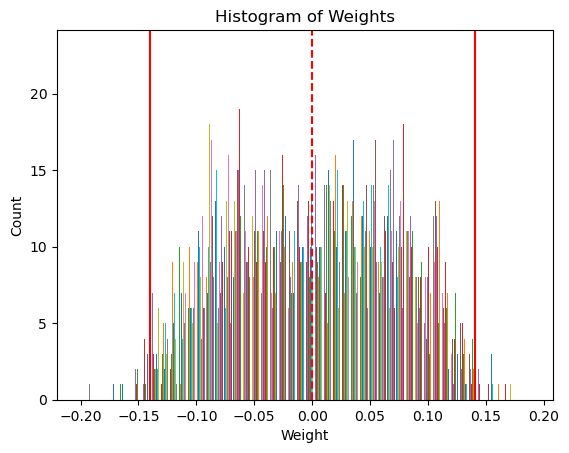

In [64]:
import matplotlib.pyplot as plt
# Calculate the mean and standard deviation of the weights.
mean = np.mean(weights)
sigma = np.std(weights)

# Plot a histogram of the weights.
plt.hist(weights, bins=50)
plt.axvline(mean, color='red', linestyle='dashed')
plt.axvline(mean + 2*sigma, color='red')
plt.axvline(mean - 2*sigma, color='red')
plt.title('Histogram of Weights')
plt.xlabel('Weight')
plt.ylabel('Count')
plt.show()

In [65]:
weights.shape

(324, 65)

In [118]:
def Tweights(weight):
    num = []

    for i in range(weight.shape[1]):
        weight_mean = np.mean(weight[:, i])
        weight_std = np.std(weight[:, i])
        threshold_upper = weight_mean + 1.5 * weight_std
        threshold_lower = weight_mean - 1.5 * weight_std
        nodes_with_weight_above_upper_threshold = np.sum(weight[:, i] > threshold_upper)
        nodes_with_weight_below_lower_threshold = np.sum(weight[:, i] < threshold_lower)
        ten_percent_nodes = int(0.1 * weight.shape[0])

        if nodes_with_weight_above_upper_threshold + nodes_with_weight_below_lower_threshold > ten_percent_nodes:
            num.append(nodes_with_weight_above_upper_threshold + nodes_with_weight_below_lower_threshold)
            print(i, nodes_with_weight_above_upper_threshold, threshold_upper, nodes_with_weight_below_lower_threshold, threshold_lower)

    return num




In [119]:
we = Tweights(weights)
we

0 26 0.09854239039123058 21 -0.11099517531692982
1 22 0.1087423405260779 16 -0.10865765152266249
2 26 0.10142504912801087 18 -0.10665612178854644
3 19 0.10922465729527175 24 -0.10206045699305832
4 14 0.10126363532617688 20 -0.10965607268735766
5 19 0.10870357742533088 25 -0.10088638076558709
6 26 0.09714971389621496 15 -0.11157543305307627
7 27 0.10319869290105999 23 -0.10593698848970234
8 19 0.10872393287718296 24 -0.10549922846257687
9 17 0.09771354589611292 24 -0.10919078346341848
10 23 0.11041404103161767 20 -0.1091142168152146
11 22 0.10729648149572313 20 -0.10938762896694243
12 21 0.1036481112241745 22 -0.10705326497554779
13 17 0.11251652019564062 20 -0.11037815583404154
14 16 0.10237404005602002 23 -0.09684155834838748
15 27 0.10678428772371262 18 -0.10500472423154861
16 23 0.11462421156466007 20 -0.10236120037734509
17 21 0.11194730643182993 20 -0.1006196578964591
18 24 0.10411681095138192 18 -0.09577443590387702
19 20 0.10461077257059515 21 -0.10258464352227747
20 22 0.108498

[47,
 38,
 44,
 43,
 34,
 44,
 41,
 50,
 43,
 41,
 43,
 42,
 43,
 37,
 39,
 45,
 43,
 41,
 42,
 41,
 47,
 49,
 42,
 46,
 41,
 42,
 45,
 44,
 42,
 42,
 36,
 39,
 39,
 46,
 39,
 39,
 40,
 46,
 39,
 44,
 42,
 48,
 53,
 38,
 41,
 46,
 38,
 42,
 40,
 41,
 47,
 34,
 40,
 45,
 45,
 39,
 42,
 44,
 42,
 37,
 42,
 43,
 43,
 44,
 47]

In [120]:
len(we)

65

In [69]:
pred = np.zeros((65,708))
for i in range(weights.shape[1]):
    weight_mean = np.mean(weights[:,i])
    weight_std = np.std(weights[:,i])
    threshold_upper = weight_mean + 1.5 * weight_std
    threshold_lower = weight_mean - 1.5 * weight_std
    nodes_with_weight_above_upper_threshold = np.sum(weights[:, i] > threshold_upper)
    nodes_with_weight_below_lower_threshold = np.sum(weights[:, i] < threshold_lower)
    ten_percent_nodes = int(0.1 * weights.shape[0])
    if (nodes_with_weight_above_upper_threshold + nodes_with_weight_below_lower_threshold) > ten_percent_nodes:
        for h in range(input_data.shape[0]): 
            pred_i = 0
            for j in range(weights.shape[0]):
                weight_value = weights[j,i]
                if weight_value > threshold_upper or weight_value < threshold_lower:
                    pp = np.sum(weight_value*input_data[h,j])
                    pred_i += pp
                    pred[i,h] = pred_i
                

print(pred)

[[ 0.01966558 -0.00309038  0.03862012 ...  0.21874785  0.10505071
   0.530508  ]
 [ 0.78450995  1.23198059  1.15954026 ...  0.80138127  0.75654569
   0.51555097]
 [ 0.82822113  0.62184319  0.80319313 ...  0.56241358  0.87268291
   0.62241508]
 ...
 [-0.7433651  -0.70824184 -0.67594819 ... -0.655242   -1.0227817
  -0.41026019]
 [ 0.61678812  0.61386877  0.61738302 ...  0.74145698  0.53061978
   0.40801078]
 [ 0.39849588  0.59865197  0.23314248 ... -0.06861502  0.53383811
  -0.03680704]]


In [70]:
weight_value

0.06302484

In [71]:
number_of_zeros = np.count_nonzero( pred == 0)

In [72]:
number_of_zeros

0

In [73]:
pred.shape

(65, 708)

In [74]:
predd = pred[12,:].reshape(59,12)
predd

array([[-2.44708013e-01, -4.99692570e-02, -4.42886490e-01,
        -2.39100679e-01, -4.18227035e-01, -4.21766678e-01,
        -3.67077323e-01, -9.75243852e-02,  8.97335305e-02,
        -2.34382619e-01, -3.70512749e-02, -3.28624884e-01],
       [-3.07043505e-01, -2.54183540e-01, -1.21993349e-01,
        -6.33040183e-01, -6.89799978e-01, -1.04464517e-01,
        -3.60313492e-01, -3.47069849e-01, -9.03381091e-02,
        -2.62092960e-01, -1.03732386e+00, -4.98124813e-01],
       [-1.59114913e-01,  1.40257800e-01, -2.28906043e-01,
        -4.34160343e-01, -5.68001147e-01, -5.69017272e-02,
        -6.15967604e-01, -5.89082777e-02, -2.01450119e-01,
         2.02596112e-01, -3.52689462e-01, -6.91969370e-01],
       [-7.72303402e-02, -1.26705968e-01, -1.62016023e-02,
        -4.57509514e-01, -6.30016653e-01, -5.97661353e-01,
        -5.79664825e-01, -1.79998048e-01, -1.21762118e-01,
        -4.13287692e-01, -7.97366154e-02, -7.29712013e-02],
       [-9.39746248e-02, -3.11119654e-01, -4.0040892

In [75]:
df = pd.read_csv("enso_index.csv")
df

,year,january,february,march,april,may,june,july,august,september,october,november,december,avg
0,1958,1.54,1.40,0.99,0.31,0.32,0.30,0.04,0.24,-0.31,-0.03,0.05,0.30,0.0675
1,1959,0.43,0.50,0.26,0.27,-0.01,-0.33,-0.28,-0.41,-0.53,0.11,-0.17,-0.05,-0.3875
2,1960,0.02,-0.24,-0.08,0.01,0.05,-0.20,-0.25,0.00,0.03,-0.07,-0.38,0.02,-0.1050
3,1961,-0.15,0.04,-0.10,0.13,-0.01,0.10,-0.32,-0.25,-0.52,-0.71,-0.19,-0.29,-0.2475
4,1962,-0.25,-0.16,-0.41,-0.32,-0.42,-0.22,-0.30,-0.13,-0.56,-0.33,-0.43,-0.49,-0.3025
5,1963,-0.32,-0.26,-0.06,-0.06,0.00,0.12,0.72,0.90,0.65,0.84,0.75,1.05,0.5975
6,1964,0.76,0.55,-0.16,-0.53,-0.74,-0.88,-0.65,-0.76,-0.93,-1.00,-1.10,-1.07,-0.8050
7,1965,-0.57,-0.36,-0.34,-0.09,0.19,0.45,0.81,1.25,1.26,1.61,1.54,1.45,0.9425
8,1966,1.13,0.83,0.83,0.54,-0.06,0.14,0.23,-0.10,-0.05,-0.05,-0.37,-0.26,0.0550
9,1967,-0.55,-0.56,-0.47,-0.53,-0.24,-0.12,-0.10,-0.31,-0.59,-0.38,-0.34,-0.35,-0.2800


In [76]:
pred_pres = pred[12,:].reshape(59,12)
years = pd.date_range(start='1958', end='2016', freq='YS').year
months = pd.date_range(start='1975-01', periods=12, freq='MS').strftime('%B')
df_pres = pd.DataFrame(pred_pres, index=years, columns=months)
df_pres = df_pres.reset_index()
df_pres['enso_avg'] = df['avg'].copy()
df_pres.loc[-1] = [1957,0,0,0,0,0, df_pres['June'][0],df_pres['July'][0],df_pres['August'][0], df_pres['September'][0],df_pres['October'][0],df_pres['November'][0],df_pres['December'][0],df_pres['enso_avg'][0]]
df_pres.index = df_pres.index + 1  # shifting index
df_pres = df_pres.sort_index() 
df_pres= df_pres.drop('index',axis=1)
df_6 = df_pres.iloc[1:, :5]
df_6 = df_6.reset_index()
df_12 = df_pres.iloc[0:-1, 5:12]
df_12 = df_12.reset_index()
df_13 = df_pres.iloc[1:, [12]]
df_13 = df_13.reset_index()
df_last = pd.concat([df_6, df_12, df_13], axis=1)
df_last = df_last.drop('index',axis=1)
correlation = df_last.corr(method='pearson')

In [77]:
df_12

,index,June,July,August,September,October,November,December
0,0,-0.421767,-0.367077,-0.097524,0.089734,-0.234383,-0.037051,-0.328625
1,1,-0.421767,-0.367077,-0.097524,0.089734,-0.234383,-0.037051,-0.328625
2,2,-0.104465,-0.360313,-0.347070,-0.090338,-0.262093,-1.037324,-0.498125
3,3,-0.056902,-0.615968,-0.058908,-0.201450,0.202596,-0.352689,-0.691969
4,4,-0.597661,-0.579665,-0.179998,-0.121762,-0.413288,-0.079737,-0.072971
5,5,-0.503332,-0.126626,0.038253,-0.361804,0.358410,-0.354410,-0.027480
6,6,0.037492,-0.189415,-0.375278,-0.095160,-0.131301,0.150498,0.065042
7,7,0.016174,0.186789,-0.000548,-0.044474,0.030937,0.318382,-0.325690
8,8,0.092924,-0.247068,0.021482,-0.450257,0.430736,-0.241421,-0.403404
9,9,-0.001656,-0.288240,0.259563,0.236666,0.372467,-0.686431,-0.853212


In [78]:
df_pres

,January,February,March,April,May,June,July,August,September,October,November,December,enso_avg
0,0.000000,0.000000,0.000000,0.000000,0.000000,-0.421767,-0.367077,-0.097524,0.089734,-0.234383,-0.037051,-0.328625,0.0675
1,-0.244708,-0.049969,-0.442886,-0.239101,-0.418227,-0.421767,-0.367077,-0.097524,0.089734,-0.234383,-0.037051,-0.328625,0.0675
2,-0.307044,-0.254184,-0.121993,-0.633040,-0.689800,-0.104465,-0.360313,-0.347070,-0.090338,-0.262093,-1.037324,-0.498125,-0.3875
3,-0.159115,0.140258,-0.228906,-0.434160,-0.568001,-0.056902,-0.615968,-0.058908,-0.201450,0.202596,-0.352689,-0.691969,-0.1050
4,-0.077230,-0.126706,-0.016202,-0.457510,-0.630017,-0.597661,-0.579665,-0.179998,-0.121762,-0.413288,-0.079737,-0.072971,-0.2475
5,-0.093975,-0.311120,-0.400409,-0.237064,0.043311,-0.503332,-0.126626,0.038253,-0.361804,0.358410,-0.354410,-0.027480,-0.3025
6,-0.272181,-0.131410,-0.386990,-0.170065,-0.496621,0.037492,-0.189415,-0.375278,-0.095160,-0.131301,0.150498,0.065042,0.5975
7,0.727354,-0.144772,0.075431,-0.250941,-0.022947,0.016174,0.186789,-0.000548,-0.044474,0.030937,0.318382,-0.325690,-0.8050
8,-0.155831,0.261659,-0.326184,-0.330372,-0.019339,0.092924,-0.247068,0.021482,-0.450257,0.430736,-0.241421,-0.403404,0.9425
9,0.193088,-0.290364,-0.311052,-0.541894,-0.227764,-0.001656,-0.288240,0.259563,0.236666,0.372467,-0.686431,-0.853212,0.0550


In [79]:
df_last

,January,February,March,April,May,June,July,August,September,October,November,December,enso_avg
0,-0.244708,-0.049969,-0.442886,-0.239101,-0.418227,-0.421767,-0.367077,-0.097524,0.089734,-0.234383,-0.037051,-0.328625,0.0675
1,-0.307044,-0.254184,-0.121993,-0.633040,-0.689800,-0.421767,-0.367077,-0.097524,0.089734,-0.234383,-0.037051,-0.328625,-0.3875
2,-0.159115,0.140258,-0.228906,-0.434160,-0.568001,-0.104465,-0.360313,-0.347070,-0.090338,-0.262093,-1.037324,-0.498125,-0.1050
3,-0.077230,-0.126706,-0.016202,-0.457510,-0.630017,-0.056902,-0.615968,-0.058908,-0.201450,0.202596,-0.352689,-0.691969,-0.2475
4,-0.093975,-0.311120,-0.400409,-0.237064,0.043311,-0.597661,-0.579665,-0.179998,-0.121762,-0.413288,-0.079737,-0.072971,-0.3025
5,-0.272181,-0.131410,-0.386990,-0.170065,-0.496621,-0.503332,-0.126626,0.038253,-0.361804,0.358410,-0.354410,-0.027480,0.5975
6,0.727354,-0.144772,0.075431,-0.250941,-0.022947,0.037492,-0.189415,-0.375278,-0.095160,-0.131301,0.150498,0.065042,-0.8050
7,-0.155831,0.261659,-0.326184,-0.330372,-0.019339,0.016174,0.186789,-0.000548,-0.044474,0.030937,0.318382,-0.325690,0.9425
8,0.193088,-0.290364,-0.311052,-0.541894,-0.227764,0.092924,-0.247068,0.021482,-0.450257,0.430736,-0.241421,-0.403404,0.0550
9,0.320342,0.039827,-0.498538,0.207369,-0.194048,-0.001656,-0.288240,0.259563,0.236666,0.372467,-0.686431,-0.853212,-0.2800


In [80]:
correlation

,January,February,March,April,May,June,July,August,September,October,November,December,enso_avg
January,1.000000,0.274853,0.038637,0.086790,0.160628,-0.014025,-0.089428,-0.058251,0.133818,0.028337,-0.042820,0.308302,-0.031961
February,0.274853,1.000000,-0.070134,0.027208,0.230027,0.327650,0.152785,-0.140229,0.074538,0.179431,-0.010217,0.331577,0.133796
March,0.038637,-0.070134,1.000000,0.148087,0.082791,0.214887,0.255120,0.107443,-0.033147,0.022976,-0.001289,-0.047135,0.001398
April,0.086790,0.027208,0.148087,1.000000,0.195593,0.253150,-0.004569,0.202131,-0.068992,0.089023,-0.073138,0.146470,0.029595
May,0.160628,0.230027,0.082791,0.195593,1.000000,0.218155,0.307829,0.132216,-0.232436,-0.045200,0.134992,0.251228,-0.117747
June,-0.014025,0.327650,0.214887,0.253150,0.218155,1.000000,0.402785,0.292360,0.007134,0.465287,0.225486,0.236326,0.065392
July,-0.089428,0.152785,0.255120,-0.004569,0.307829,0.402785,1.000000,0.363673,0.112078,0.389759,0.319711,0.155456,0.107773
August,-0.058251,-0.140229,0.107443,0.202131,0.132216,0.292360,0.363673,1.000000,0.093844,0.336399,0.242322,0.110446,-0.065645
September,0.133818,0.074538,-0.033147,-0.068992,-0.232436,0.007134,0.112078,0.093844,1.000000,-0.064869,0.005128,-0.001732,0.211829
October,0.028337,0.179431,0.022976,0.089023,-0.045200,0.465287,0.389759,0.336399,-0.064869,1.000000,0.323113,0.144882,0.076631


In [81]:
def potential_predictors_new(data):
    global top_correlation
    top_correlation = []
    top_preds = pd.DataFrame()
    for i in range(65):
        pred_pres = data[i,:].reshape(59,12)
        # Create year and month ranges
        years = pd.date_range(start='1958', end='2016', freq='YS').year
        months = pd.date_range(start='1975-01', periods=12, freq='MS').strftime('%B')
        # Create the DataFrame
        
        df_pres = pd.DataFrame(pred_pres, index=years, columns=months)
        df_pres = df_pres.reset_index()
        df_pres['enso_avg'] = df['avg'].copy()
        df_pres.loc[-1] = [1957,0,0,0,0,0, df_pres['June'][0],df_pres['July'][0],df_pres['August'][0], df_pres['September'][0],df_pres['October'][0],df_pres['November'][0],df_pres['December'][0],df_pres['enso_avg'][0]]
        df_pres.index = df_pres.index + 1  # shifting index
        df_pres = df_pres.sort_index() 
        df_pres= df_pres.drop('index',axis=1)
        df_6 = df_pres.iloc[1:, :5]
        df_6 = df_6.reset_index()
        df_12 = df_pres.iloc[0:-1, 5:12]
        df_12 = df_12.reset_index()
        df_13 = df_pres.iloc[1:, [12]]
        df_13 = df_13.reset_index()
        df_last = pd.concat([df_6, df_12, df_13], axis=1)
        df_last = df_last.drop('index',axis=1)
        correlation = df_last.corr(method='pearson')
        second_max_value = correlation['enso_avg'].sort_values(ascending=False)[1]
        negative_minimum = correlation['enso_avg'].sort_values(ascending=False)[-1]
        second_max_index = correlation['enso_avg'].sort_values(ascending=False).index[1]
        negative_min_index = correlation['enso_avg'].sort_values(ascending=False).index[-1]
        if abs(second_max_value) > abs(negative_minimum):
            highest_correlation = second_max_value
            highest_correlation_index = second_max_index
            
        else:
            highest_correlation = negative_minimum
            highest_correlation_index = negative_min_index
            
        column_name = highest_correlation_index
        suffix_index = 1
        while column_name in top_preds.columns:
            suffix_index += 1
            column_name = f"{highest_correlation_index}_{suffix_index}"
        
        top_preds[column_name] = df_last[highest_correlation_index]
        top_correlation.append((i, highest_correlation,column_name , abs(highest_correlation)))
        print(i,highest_correlation,column_name,abs(highest_correlation))
        result_df = pd.DataFrame(top_correlation, columns=['Iteration', 'Correlation', 'Column_Name', 'Absolute_Correlation'])
    return top_preds,result_df
        
    

In [82]:
top_predp,resultp = potential_predictors_new(pred)

0 -0.19403774228917192 August 0.19403774228917192
1 -0.4035193167453365 November 0.4035193167453365
2 -0.30477683035071756 April 0.30477683035071756
3 0.23816704529055469 March 0.23816704529055469
4 -0.33021777229750904 March_2 0.33021777229750904
5 0.31967945450955293 November_2 0.31967945450955293
6 -0.34089773626881675 July 0.34089773626881675
7 0.280930723923125 June 0.280930723923125
8 -0.24762988374699524 January 0.24762988374699524
9 -0.2172806579961555 July_2 0.2172806579961555
10 -0.3129473195301687 June_2 0.3129473195301687
11 -0.3014024422656048 May 0.3014024422656048
12 0.21182894542959554 September 0.21182894542959554
13 -0.4163688465561503 May_2 0.4163688465561503
14 0.171405778779818 April_2 0.171405778779818
15 -0.28721123275938615 March_3 0.28721123275938615
16 0.3177523911891442 June_3 0.3177523911891442
17 0.16452681771419692 January_2 0.16452681771419692
18 -0.22537056751153914 July_3 0.22537056751153914
19 -0.31931438894980463 August_2 0.31931438894980463
20 0.2157

In [83]:
resultp = resultp.sort_values(by='Absolute_Correlation', ascending=False)
resultp

,Iteration,Correlation,Column_Name,Absolute_Correlation
35,35,-0.483489,April_5,0.483489
47,47,-0.441645,July_7,0.441645
13,13,-0.416369,May_2,0.416369
44,44,0.414343,March_4,0.414343
55,55,-0.406502,November_7,0.406502
...,...,...,...,...
14,14,0.171406,April_2,0.171406
24,24,-0.171006,July_4,0.171006
17,17,0.164527,January_2,0.164527
48,48,0.139424,November_5,0.139424


In [84]:
top_predp['March_2']

0    -0.485354
1    -0.522444
2    -0.766616
3    -0.287082
4    -0.334403
5    -0.938329
6    -0.746963
7    -0.448006
8    -0.610180
9    -0.460374
10   -0.246833
11   -0.361805
12    0.023022
13   -0.446195
14   -0.570936
15   -0.375242
16   -0.388779
17   -0.222553
18   -0.327462
19   -0.347669
20   -0.388093
21   -0.306163
22   -0.694565
23   -0.052322
24   -0.406899
25   -0.373943
26   -0.212854
27   -0.316845
28   -0.424246
29   -0.253166
30   -0.142318
31   -0.565738
32   -0.308672
33   -0.569454
34   -0.234353
35   -0.239302
36   -0.110661
37   -0.299283
38   -0.372112
39   -0.678987
40   -0.264579
41   -0.250715
42   -0.214940
43   -0.152314
44   -0.802103
45   -0.438145
46   -0.699231
47   -0.310525
48   -0.245323
49   -0.490251
50   -0.473080
51   -0.437078
52   -0.169068
53   -0.333729
54   -0.460317
55   -0.386870
56   -0.523143
57   -0.388638
58   -0.436360
Name: March_2, dtype: float64

In [85]:
unique_values_listp = resultp['Column_Name'].unique().tolist()

In [86]:
top_predp = top_predp[unique_values_listp]

In [87]:
top_predp

,April_5,July_7,May_2,March_4,November_7,August_6,November,March_5,April_6,February,...,May_5,June_7,August,October_3,May_6,April_2,July_4,January_2,November_5,November_4
0,0.386355,-0.687068,-0.359395,0.248808,0.052698,0.085345,0.541902,-0.157927,-0.301686,-0.071518,...,0.270275,0.236085,0.095540,-0.883223,0.321929,-0.486513,-0.242583,0.318769,-0.084397,0.016011
1,0.200515,-0.687068,-0.410397,0.332242,0.052698,0.085345,0.541902,-0.009811,-0.234569,-0.270065,...,0.148937,0.236085,0.095540,-0.883223,0.475003,-0.655802,-0.242583,0.156436,-0.084397,0.016011
2,0.018638,-0.379167,0.172456,0.499594,0.284734,0.065937,0.607633,0.122192,-0.365373,-0.515648,...,-0.013905,0.312541,-0.315493,-0.645719,0.264791,-0.353554,-0.400509,0.111942,-0.219216,0.108613
3,0.151849,-0.152717,-0.222168,0.411549,0.236467,0.086337,0.524124,-0.161060,-0.265705,-0.300107,...,0.362276,0.266322,-0.036190,-0.605081,0.688802,-0.796001,-0.385096,-0.079325,-0.355519,0.039167
4,-0.119454,-0.366530,-0.023508,0.627389,0.120395,0.074738,0.624625,-0.443562,-0.288098,-0.317107,...,0.230757,0.386268,0.242084,-0.575406,0.049873,-0.564111,-0.373572,-0.013466,-0.364060,0.283292
5,0.151046,-0.611835,-0.364834,0.355478,0.046850,0.146513,0.615718,-0.237918,-0.398197,-0.272964,...,0.378412,0.274103,0.040723,-0.283427,0.503813,-0.586393,-0.426339,-0.065686,-0.456475,0.161630
6,0.134536,-0.899686,-0.415197,-0.040398,0.324169,0.110645,0.766336,-0.047212,-0.270109,0.271517,...,0.249505,-0.140598,0.090950,-0.218197,-0.171574,-0.568503,-0.529695,0.237293,-0.314178,0.284418
7,-0.374646,-0.829043,-0.140117,0.596792,-0.087662,0.313885,0.243056,-0.731831,-0.436468,-0.423704,...,0.443796,0.134127,-0.059995,-0.354213,0.219573,-0.483380,-0.396949,0.093264,-0.483590,0.336487
8,0.330437,-0.550519,-0.279670,0.507744,0.113202,0.431951,0.880321,-0.146678,-0.204309,-0.095781,...,0.141880,0.211408,0.059821,-0.426546,-0.035389,-0.499771,-0.107674,0.090071,-0.326851,0.176422
9,-0.261064,-0.385054,-0.328111,0.639965,-0.288817,0.296296,0.571846,-0.114512,-0.407113,-0.330888,...,0.612563,-0.273739,-0.001853,-0.439407,0.242125,-0.448221,-0.255241,0.327870,-0.267723,-0.259699


In [88]:
top_predp.to_csv('pearson_corr.csv', index=False)

In [89]:
def potential_predictors_new(data):
    global top_correlation
    top_correlation = []
    top_preds = pd.DataFrame()
    for i in range(65):
        pred_pres = data[i,:].reshape(59,12)
        # Create year and month ranges
        years = pd.date_range(start='1958', end='2016', freq='YS').year
        months = pd.date_range(start='1975-01', periods=12, freq='MS').strftime('%B')
        # Create the DataFrame
        
        df_pres = pd.DataFrame(pred_pres, index=years, columns=months)
        df_pres = df_pres.reset_index()
        df_pres['enso_avg'] = df['avg'].copy()
        df_pres.loc[-1] = [1957,0,0,0,0,0, df_pres['June'][0],df_pres['July'][0],df_pres['August'][0], df_pres['September'][0],df_pres['October'][0],df_pres['November'][0],df_pres['December'][0],df_pres['enso_avg'][0]]
        df_pres.index = df_pres.index + 1  # shifting index
        df_pres = df_pres.sort_index() 
        df_pres= df_pres.drop('index',axis=1)
        df_6 = df_pres.iloc[1:, :5]
        df_6 = df_6.reset_index()
        df_12 = df_pres.iloc[0:-1, 5:12]
        df_12 = df_12.reset_index()
        df_13 = df_pres.iloc[1:, [12]]
        df_13 = df_13.reset_index()
        df_last = pd.concat([df_6, df_12, df_13], axis=1)
        df_last = df_last.drop('index',axis=1)
        correlation = df_last.corr(method='kendall')
        second_max_value = correlation['enso_avg'].sort_values(ascending=False)[1]
        negative_minimum = correlation['enso_avg'].sort_values(ascending=False)[-1]
        second_max_index = correlation['enso_avg'].sort_values(ascending=False).index[1]
        negative_min_index = correlation['enso_avg'].sort_values(ascending=False).index[-1]
        if abs(second_max_value) > abs(negative_minimum):
            highest_correlation = second_max_value
            highest_correlation_index = second_max_index
            
        else:
            highest_correlation = negative_minimum
            highest_correlation_index = negative_min_index
            
        column_name = highest_correlation_index
        suffix_index = 1
        while column_name in top_preds.columns:
            suffix_index += 1
            column_name = f"{highest_correlation_index}_{suffix_index}"
        
        top_preds[column_name] = df_last[highest_correlation_index]
        top_correlation.append((i, highest_correlation,column_name , abs(highest_correlation)))
        print(i,highest_correlation,column_name,abs(highest_correlation))
        result_df = pd.DataFrame(top_correlation, columns=['Iteration', 'Correlation', 'Column_Name', 'Absolute_Correlation'])
    return top_preds,result_df
        
    

In [90]:
top_predk,resultk = potential_predictors_new(pred)

0 -0.15335095169878848 August 0.15335095169878848
1 -0.28797201616719054 November 0.28797201616719054
2 -0.21825643968411093 April 0.21825643968411093
3 0.16154527736208252 November_2 0.16154527736208252
4 -0.21240506060410796 March 0.21240506060410796
5 0.1943225800152587 November_3 0.1943225800152587
6 -0.259877185321611 July 0.259877185321611
7 0.1545215696506876 June 0.1545215696506876
8 -0.1784670619400907 January 0.1784670619400907
9 -0.1556921876025868 July_2 0.1556921876025868
10 -0.23178235447603143 June_2 0.23178235447603143
11 -0.18548871683609428 May 0.18548871683609428
12 0.13048575348406632 February 0.13048575348406632
13 -0.2779405063001413 May_2 0.2779405063001413
14 0.1322798285646038 November_4 0.1322798285646038
15 -0.2299591978441169 March_2 0.2299591978441169
16 0.2189055570051408 June_3 0.2189055570051408
17 0.13345044651650295 September 0.13345044651650295
18 -0.20251690567855274 July_3 0.20251690567855274
19 -0.2715833648406025 August_2 0.2715833648406025
20 0.1

In [91]:
resultk = resultk.sort_values(by='Absolute_Correlation', ascending=False)
resultk

,Iteration,Correlation,Column_Name,Absolute_Correlation
47,47,-0.321920,July_6,0.321920
35,35,-0.300176,April_5,0.300176
55,55,-0.297337,November_7,0.297337
1,1,-0.287972,November,0.287972
64,64,0.279778,August_5,0.279778
...,...,...,...,...
33,33,-0.127597,June_6,0.127597
20,20,0.117062,December,0.117062
46,46,0.115891,June_9,0.115891
23,23,0.115272,January_2,0.115272


In [92]:
top_predk['March_4']

0    -0.323441
1    -0.333743
2    -0.217110
3    -0.130204
4    -0.162118
5    -0.401284
6    -0.477835
7    -0.186026
8    -0.663481
9    -0.388100
10   -0.101395
11   -0.057528
12   -0.241778
13   -0.167392
14   -0.404683
15    0.118247
16   -0.153680
17   -0.317260
18   -0.641712
19   -0.315876
20   -0.140112
21   -0.295565
22   -0.389487
23   -0.493714
24   -0.300032
25   -0.091592
26   -0.209910
27   -0.450267
28   -0.383986
29   -0.406845
30   -0.196502
31   -0.295558
32    0.132927
33   -0.437657
34   -0.216494
35   -0.163041
36   -0.049563
37   -0.217535
38   -0.257909
39   -0.392040
40    0.030223
41   -0.601662
42   -0.060308
43   -0.289902
44   -0.259083
45   -0.177616
46   -0.392723
47    0.026296
48   -0.224526
49   -0.341831
50   -0.324036
51   -0.541539
52   -0.335133
53   -0.204406
54   -0.608011
55   -0.267499
56   -0.004525
57   -0.071179
58    0.180567
Name: March_4, dtype: float64

In [93]:
unique_values_listk = resultk['Column_Name'].unique().tolist()

In [94]:
top_predk = top_predk[unique_values_listk]

In [95]:
top_predk

,July_6,April_5,November_7,November,August_5,May_2,August_2,February_2,June_8,July,...,July_5,September,November_4,February,June_5,June_6,December,June_9,January_2,March_4
0,-0.687068,0.386355,0.052698,0.541902,0.085345,-0.359395,-0.164586,-0.071518,0.214528,0.511440,...,0.159064,0.021619,-0.412337,-0.049969,0.097371,0.236085,-0.392784,0.117797,0.281266,-0.323441
1,-0.687068,0.200515,0.052698,0.541902,0.085345,-0.410397,-0.164586,-0.270065,0.214528,0.511440,...,0.159064,0.021619,-0.412337,-0.254184,0.097371,0.236085,-0.392784,0.117797,0.093712,-0.333743
2,-0.379167,0.018638,0.284734,0.607633,0.065937,0.172456,-0.042086,-0.515648,-0.028833,0.592537,...,0.284638,0.387369,-0.488257,0.140258,0.092709,0.312541,-0.086383,0.410454,0.299865,-0.217110
3,-0.152717,0.151849,0.236467,0.524124,0.086337,-0.222168,-0.103642,-0.300107,0.284881,0.421409,...,0.243336,0.112207,-0.420340,-0.126706,-0.018425,0.266322,-0.302824,0.253097,0.283977,-0.130204
4,-0.366530,-0.119454,0.120395,0.624625,0.074738,-0.023508,0.155223,-0.317107,0.243538,0.299698,...,0.103757,0.198025,-0.510549,-0.311120,0.118394,0.386268,-0.401714,0.279657,-0.082800,-0.162118
5,-0.611835,0.151046,0.046850,0.615718,0.146513,-0.364834,0.081915,-0.272964,0.324546,0.069961,...,0.472867,-0.123769,-0.651821,-0.131410,0.118922,0.274103,-0.234601,0.386663,0.313494,-0.401284
6,-0.899686,0.134536,0.324169,0.766336,0.110645,-0.415197,0.370244,0.271517,0.224038,0.221311,...,0.047173,0.015626,-0.574150,-0.144772,-0.033417,-0.140598,-0.675032,0.247686,0.024788,-0.477835
7,-0.829043,-0.374646,-0.087662,0.243056,0.313885,-0.140117,-0.058799,-0.423704,-0.279221,0.326745,...,0.083969,0.377184,-0.701288,0.261659,0.216658,0.134127,-0.329000,0.294722,0.321964,-0.186026
8,-0.550519,0.330437,0.113202,0.880321,0.431951,-0.279670,-0.224176,-0.095781,0.371503,0.251424,...,0.108484,-0.061076,-0.494259,-0.290364,0.073189,0.211408,-0.247365,0.213540,0.078951,-0.663481
9,-0.385054,-0.261064,-0.288817,0.571846,0.296296,-0.328111,0.036304,-0.330888,-0.209118,0.442840,...,-0.025386,0.489972,-0.479131,0.039827,0.388498,-0.273739,-0.245567,0.048790,0.269230,-0.388100


In [96]:
top_predk.to_csv('kendall_corr.csv', index=False)

In [97]:
def potential_predictors_new(data):
    global top_correlation
    top_correlation = []
    top_preds = pd.DataFrame()
    for i in range(65):
        pred_pres = data[i,:].reshape(59,12)
        # Create year and month ranges
        years = pd.date_range(start='1958', end='2016', freq='YS').year
        months = pd.date_range(start='1975-01', periods=12, freq='MS').strftime('%B')
        # Create the DataFrame
        
        df_pres = pd.DataFrame(pred_pres, index=years, columns=months)
        df_pres = df_pres.reset_index()
        df_pres['enso_avg'] = df['avg'].copy()
        df_pres.loc[-1] = [1957,0,0,0,0,0, df_pres['June'][0],df_pres['July'][0],df_pres['August'][0], df_pres['September'][0],df_pres['October'][0],df_pres['November'][0],df_pres['December'][0],df_pres['enso_avg'][0]]
        df_pres.index = df_pres.index + 1  # shifting index
        df_pres = df_pres.sort_index() 
        df_pres= df_pres.drop('index',axis=1)
        df_6 = df_pres.iloc[1:, :5]
        df_6 = df_6.reset_index()
        df_12 = df_pres.iloc[0:-1, 5:12]
        df_12 = df_12.reset_index()
        df_13 = df_pres.iloc[1:, [12]]
        df_13 = df_13.reset_index()
        df_last = pd.concat([df_6, df_12, df_13], axis=1)
        df_last = df_last.drop('index',axis=1)
        correlation = df_last.corr(method='spearman')
        second_max_value = correlation['enso_avg'].sort_values(ascending=False)[1]
        negative_minimum = correlation['enso_avg'].sort_values(ascending=False)[-1]
        second_max_index = correlation['enso_avg'].sort_values(ascending=False).index[1]
        negative_min_index = correlation['enso_avg'].sort_values(ascending=False).index[-1]
        if abs(second_max_value) > abs(negative_minimum):
            highest_correlation = second_max_value
            highest_correlation_index = second_max_index
            
        else:
            highest_correlation = negative_minimum
            highest_correlation_index = negative_min_index
            
        column_name = highest_correlation_index
        suffix_index = 1
        while column_name in top_preds.columns:
            suffix_index += 1
            column_name = f"{highest_correlation_index}_{suffix_index}"
        
        top_preds[column_name] = df_last[highest_correlation_index]
        top_correlation.append((i, highest_correlation,column_name , abs(highest_correlation)))
        print(i,highest_correlation,column_name,abs(highest_correlation))
        result_df = pd.DataFrame(top_correlation, columns=['Iteration', 'Correlation', 'Column_Name', 'Absolute_Correlation'])
    return top_preds,result_df
        
    

In [98]:
top_preds,results = potential_predictors_new(pred)

0 -0.20244027198526526 August 0.20244027198526526
1 -0.415810623618645 November 0.415810623618645
2 -0.3285989835526976 April 0.3285989835526976
3 0.2502520642427929 November_2 0.2502520642427929
4 -0.3147174007363039 March 0.3147174007363039
5 0.2979469572527471 November_3 0.2979469572527471
6 -0.36668371482591644 July 0.36668371482591644
7 0.235990356038836 June 0.235990356038836
8 -0.2725466133593435 January 0.2725466133593435
9 -0.2228684154987199 July_2 0.2228684154987199
10 -0.3673558854994636 June_2 0.3673558854994636
11 -0.2547781873543595 May 0.2547781873543595
12 0.1872990826742475 February 0.1872990826742475
13 -0.3929218546661348 May_2 0.3929218546661348
14 0.1989625193699561 November_4 0.1989625193699561
15 -0.3422175469052018 March_2 0.3422175469052018
16 0.34660626905518205 June_3 0.34660626905518205
17 0.19373127804104567 September 0.19373127804104567
18 -0.30417184218603155 July_3 0.30417184218603155
19 -0.397749689868552 August_2 0.397749689868552
20 0.193818952476725

In [99]:
results = results.sort_values(by='Absolute_Correlation', ascending=False)
results

,Iteration,Correlation,Column_Name,Absolute_Correlation
47,47,-0.469789,July_6,0.469789
35,35,-0.456105,April_6,0.456105
55,55,-0.429488,November_7,0.429488
1,1,-0.415811,November,0.415811
64,64,0.400175,July_7,0.400175
...,...,...,...,...
33,33,-0.189026,June_6,0.189026
12,12,0.187299,February,0.187299
23,23,-0.181220,April_3,0.181220
46,46,0.172602,June_9,0.172602


In [100]:
top_preds

,August,November,April,November_2,March,November_3,July,June,January,July_2,...,November_7,December_2,April_10,September_5,February_5,March_5,August_5,November_8,May_4,July_7
0,0.095540,0.541902,0.819614,0.050461,-0.485354,-0.661083,0.511440,-0.065246,-0.402038,-0.409337,...,0.052698,0.515092,-0.148039,-0.391982,0.046566,-0.157927,0.401088,-0.383951,0.321929,0.005747
1,0.095540,0.541902,0.564255,0.050461,-0.522444,-0.661083,0.511440,-0.065246,-0.854662,-0.409337,...,0.052698,0.515092,-0.317571,-0.391982,-0.087488,-0.009811,0.401088,-0.383951,0.475003,0.005747
2,-0.315493,0.607633,0.287186,0.137030,-0.766616,-0.718492,0.592537,0.082068,-0.705998,-0.303463,...,0.284734,0.207957,0.212617,-0.450753,0.171106,0.122192,-0.236917,-0.773250,0.264791,-0.021631
3,-0.036190,0.524124,0.651520,0.035587,-0.287082,-0.323172,0.421409,0.135700,-0.318306,-0.297750,...,0.236467,0.517935,-0.169723,-0.807934,0.193897,-0.161060,0.334215,-0.381501,0.688802,-0.039958
4,0.242084,0.624625,0.110112,-0.329205,-0.334403,-0.416463,0.299698,0.099286,-0.579056,-0.253425,...,0.120395,0.260469,0.149711,-0.632761,-0.129888,-0.443562,0.106076,-0.413515,0.049873,0.138605
5,0.040723,0.615718,0.471448,-0.266422,-0.938329,-0.012021,0.069961,0.258202,-0.764938,-0.487378,...,0.046850,0.404557,-0.150344,-0.658004,0.142340,-0.237918,0.301936,-1.054070,0.503813,0.180762
6,0.090950,0.766336,0.689810,-0.239400,-0.746963,-0.403346,0.221311,0.228983,-0.493906,-0.323341,...,0.324169,0.322912,0.031051,-0.581625,0.095785,-0.047212,0.118807,0.169576,-0.171574,0.273354
7,-0.059995,0.243056,0.130194,-0.324755,-0.448006,0.051705,0.326745,-0.085689,-0.496836,-0.614055,...,-0.087662,0.588965,0.098786,-1.021369,-0.012049,-0.731831,0.039816,-0.516678,0.219573,0.781560
8,0.059821,0.880321,0.767261,-0.313748,-0.610180,-0.375461,0.251424,0.301458,-0.466858,-0.296561,...,0.113202,0.541155,-0.052669,-0.821782,0.035188,-0.146678,0.127491,-0.605402,-0.035389,0.421596
9,-0.001853,0.571846,-0.002892,-0.260592,-0.460374,-0.148205,0.442840,0.042599,-0.561497,-0.515002,...,-0.288817,0.609737,0.157743,-0.614157,0.417054,-0.114512,0.418463,-0.627252,0.242125,0.230158


In [101]:
results = results.sort_values(by='Absolute_Correlation', ascending=False)
results

,Iteration,Correlation,Column_Name,Absolute_Correlation
47,47,-0.469789,July_6,0.469789
35,35,-0.456105,April_6,0.456105
55,55,-0.429488,November_7,0.429488
1,1,-0.415811,November,0.415811
64,64,0.400175,July_7,0.400175
...,...,...,...,...
33,33,-0.189026,June_6,0.189026
12,12,0.187299,February,0.187299
23,23,-0.181220,April_3,0.181220
46,46,0.172602,June_9,0.172602


In [102]:
unique_values_lists = results['Column_Name'].unique().tolist()

In [103]:
top_preds = top_preds[unique_values_lists]

In [104]:
top_preds

,July_6,April_6,November_7,November,July_7,August_2,May_2,June_8,February_2,June_2,...,August,November_4,June_5,December,September,June_6,February,April_3,June_9,March_4
0,-0.687068,0.386355,0.052698,0.541902,0.005747,-0.164586,-0.359395,0.214528,-0.071518,0.164901,...,0.095540,-0.412337,0.097371,-0.392784,0.021619,0.236085,-0.049969,0.189133,0.117797,-0.323441
1,-0.687068,0.200515,0.052698,0.541902,0.005747,-0.164586,-0.410397,0.214528,-0.270065,0.164901,...,0.095540,-0.412337,0.097371,-0.392784,0.021619,0.236085,-0.254184,0.322347,0.117797,-0.333743
2,-0.379167,0.018638,0.284734,0.607633,-0.021631,-0.042086,0.172456,-0.028833,-0.515648,0.755739,...,-0.315493,-0.488257,0.092709,-0.086383,0.387369,0.312541,0.140258,0.110589,0.410454,-0.217110
3,-0.152717,0.151849,0.236467,0.524124,-0.039958,-0.103642,-0.222168,0.284881,-0.300107,0.532224,...,-0.036190,-0.420340,-0.018425,-0.302824,0.112207,0.266322,-0.126706,0.150980,0.253097,-0.130204
4,-0.366530,-0.119454,0.120395,0.624625,0.138605,0.155223,-0.023508,0.243538,-0.317107,0.598974,...,0.242084,-0.510549,0.118394,-0.401714,0.198025,0.386268,-0.311120,0.151059,0.279657,-0.162118
5,-0.611835,0.151046,0.046850,0.615718,0.180762,0.081915,-0.364834,0.324546,-0.272964,0.110380,...,0.040723,-0.651821,0.118922,-0.234601,-0.123769,0.274103,-0.131410,0.269302,0.386663,-0.401284
6,-0.899686,0.134536,0.324169,0.766336,0.273354,0.370244,-0.415197,0.224038,0.271517,0.509402,...,0.090950,-0.574150,-0.033417,-0.675032,0.015626,-0.140598,-0.144772,0.565366,0.247686,-0.477835
7,-0.829043,-0.374646,-0.087662,0.243056,0.781560,-0.058799,-0.140117,-0.279221,-0.423704,0.674860,...,-0.059995,-0.701288,0.216658,-0.329000,0.377184,0.134127,0.261659,0.331496,0.294722,-0.186026
8,-0.550519,0.330437,0.113202,0.880321,0.421596,-0.224176,-0.279670,0.371503,-0.095781,0.133733,...,0.059821,-0.494259,0.073189,-0.247365,-0.061076,0.211408,-0.290364,0.052905,0.213540,-0.663481
9,-0.385054,-0.261064,-0.288817,0.571846,0.230158,0.036304,-0.328111,-0.209118,-0.330888,0.334535,...,-0.001853,-0.479131,0.388498,-0.245567,0.489972,-0.273739,0.039827,0.202371,0.048790,-0.388100


In [105]:
top_preds.to_csv('spearman_corr.csv', index=False)

In [106]:
from sklearn.feature_selection import mutual_info_regression

def potential_predictors_new(data):
    global top_correlation
    top_correlation = []
    top_predd = pd.DataFrame()
    
    for i in range(65):
        pred_pres = data[i,:].reshape(59,12)
        # Create year and month ranges
        years = pd.date_range(start='1958', end='2016', freq='YS').year
        months = pd.date_range(start='1975-01', periods=12, freq='MS').strftime('%B')
        
        # Create the DataFrame
        df_pres = pd.DataFrame(pred_pres, index=years, columns=months)
        df_pres = df_pres.reset_index()
        df_pres['enso_avg'] = df['avg'].copy()
        df_pres.loc[-1] = [1957, 0, 0, 0, 0, 0, df_pres['June'][0], df_pres['July'][0], df_pres['August'][0], df_pres['September'][0], df_pres['October'][0], df_pres['November'][0], df_pres['December'][0], df_pres['enso_avg'][0]]
        df_pres.index = df_pres.index + 1  # Shifting index
        df_pres = df_pres.sort_index() 
        df_pres = df_pres.drop('index', axis=1)
        df_6 = df_pres.iloc[1:, :5]
        df_6 = df_6.reset_index()
        df_12 = df_pres.iloc[0:-1, 5:12]
        df_12 = df_12.reset_index()
        df_13 = df_pres.iloc[1:, [12]]
        df_13 = df_13.reset_index()
        df_last = pd.concat([df_6, df_12, df_13], axis=1)
        df_last = df_last.drop('index', axis=1)
        
        # Calculate mutual information
        features = df_last.drop('enso_avg', axis=1)
        target = df_last['enso_avg']
        mutual_info = mutual_info_regression(features, target)
        
        highest_mutual_info_index = np.argmax(mutual_info)
        highest_mutual_info_value = mutual_info[highest_mutual_info_index]
        highest_mutual_info_column = df_last.columns[highest_mutual_info_index]

        column_name = highest_mutual_info_column
        suffix_index = 1
        while column_name in top_predd.columns:
            suffix_index += 1
            column_name = f"{highest_mutual_info_column}_{suffix_index}"
        
        top_predd[column_name] = df_last[highest_mutual_info_column]
        top_correlation.append((i, highest_mutual_info_value, column_name, abs(highest_mutual_info_value)))
        print(i, highest_mutual_info_value, column_name, abs(highest_mutual_info_value))
        
    result_df = pd.DataFrame(top_correlation, columns=['Iteration', 'Mutual_Information', 'Column_Name', 'Absolute_Mutual_Information'])
    return top_predd, result_df


In [107]:
top_predm,resultm = potential_predictors_new(pred)

0 0.08165268491434441 July 0.08165268491434441
1 0.27707040021336793 November 0.27707040021336793
2 0.17574717252468508 April 0.17574717252468508
3 0.12301582225197905 February 0.12301582225197905
4 0.10343987414202216 February_2 0.10343987414202216
5 0.12366216952685605 October 0.12366216952685605
6 0.07309352920412016 February_3 0.07309352920412016
7 0.10644579870230952 March 0.10644579870230952
8 0.1844554180157334 December 0.1844554180157334
9 0.11563908038016546 September 0.11563908038016546
10 0.14246241139273597 July_2 0.14246241139273597
11 0.11245258031798544 August 0.11245258031798544
12 0.10007406363898985 June 0.10007406363898985
13 0.10585913266875169 April_2 0.10585913266875169
14 0.10053653163771381 December_2 0.10053653163771381
15 0.1199823310414696 March_2 0.1199823310414696
16 0.1808937549304046 April_3 0.1808937549304046
17 0.0344527662356362 April_4 0.0344527662356362
18 0.10005067804788581 February_4 0.10005067804788581
19 0.1405744125248285 August_2 0.14057441252

In [108]:
top_predm

,July,November,April,February,February_2,October,February_3,March,December,September,...,July_8,April_12,May_4,September_5,June_6,November_4,July_9,January_5,August_3,July_10
0,0.199806,0.541902,0.819614,-0.368332,-0.239638,-0.404408,0.623344,0.215966,-0.617522,-0.415383,...,0.384369,0.607005,0.052645,-0.391982,0.162060,0.263313,0.600460,-0.743365,0.460193,0.005747
1,0.199806,0.541902,0.564255,-0.025676,-0.702065,-0.404408,0.385728,0.195323,-0.617522,-0.415383,...,0.384369,0.627802,-0.157266,-0.391982,0.162060,0.263313,0.600460,-0.629593,0.460193,0.005747
2,-0.147069,0.607633,0.287186,-0.191249,-0.566281,-0.420134,0.325370,0.063183,-0.016267,-0.643792,...,0.135436,0.341947,0.138237,-0.450753,0.026639,0.362668,0.169065,-0.848766,0.128348,-0.021631
3,0.123751,0.524124,0.651520,-0.190316,-0.407227,-0.331647,0.422466,0.304068,-0.304587,-0.746399,...,0.289387,0.452523,0.014471,-0.807934,0.036788,-0.120214,0.192244,-0.655562,0.365950,-0.039958
4,0.183527,0.624625,0.110112,-0.231990,-0.556545,-0.553548,0.167356,0.821997,-0.292032,-0.339681,...,0.090979,0.545808,0.040301,-0.632761,0.229212,0.027303,0.105571,-0.040447,0.056266,0.138605
5,0.028357,0.615718,0.471448,-0.182288,-0.479078,-0.208514,-0.013500,-0.003455,-0.350780,-0.282218,...,0.030172,0.432132,-0.068812,-0.658004,0.181374,-0.167507,0.445825,-0.499110,0.224725,0.180762
6,0.059123,0.766336,0.689810,-0.385382,-0.274798,-0.343302,0.452278,-0.155065,-0.516449,-0.563822,...,0.344834,0.269890,0.182652,-0.581625,0.012054,-0.298025,0.260131,-0.494062,-0.030472,0.273354
7,-0.011808,0.243056,0.130194,-0.632012,-0.969573,-0.147161,0.069572,0.485057,-0.373245,-0.475357,...,-0.122420,0.480452,0.092837,-1.021369,0.131064,-0.268427,-0.029251,-0.627302,0.349213,0.781560
8,0.043259,0.880321,0.767261,-0.376226,-0.510727,-0.117616,0.481602,0.419269,-0.485148,-0.282363,...,0.222706,0.612681,0.543639,-0.821782,0.114971,-0.031475,0.195868,-0.374039,0.446713,0.421596
9,0.267095,0.571846,-0.002892,0.009459,-0.577629,-0.325113,0.304208,0.093503,0.020924,-0.583381,...,0.084428,0.434067,0.034224,-0.614157,0.262240,-0.102781,0.348041,-0.619002,0.386324,0.230158


In [109]:
resultm

,Iteration,Mutual_Information,Column_Name,Absolute_Mutual_Information
0,0,0.081653,July,0.081653
1,1,0.277070,November,0.277070
2,2,0.175747,April,0.175747
3,3,0.123016,February,0.123016
4,4,0.103440,February_2,0.103440
...,...,...,...,...
60,60,0.084820,November_4,0.084820
61,61,0.047303,July_9,0.047303
62,62,0.054905,January_5,0.054905
63,63,0.165187,August_3,0.165187


In [110]:
resultm = resultm.sort_values(by='Absolute_Mutual_Information', ascending=False)
resultm

,Iteration,Mutual_Information,Column_Name,Absolute_Mutual_Information
23,23,0.332793,April_7,0.332793
1,1,0.277070,November,0.277070
34,34,0.270101,January_2,0.270101
50,50,0.261021,January_3,0.261021
58,58,0.217348,September_5,0.217348
...,...,...,...,...
61,61,0.047303,July_9,0.047303
39,39,0.042478,June_4,0.042478
38,38,0.041775,October_4,0.041775
17,17,0.034453,April_4,0.034453


In [111]:
unique_values_listm = resultm['Column_Name'].unique().tolist()

In [112]:
top_predm = top_predm[unique_values_listm]

In [113]:
top_predm

,April_7,November,January_2,January_3,September_5,April_12,January_4,July_8,December,July_6,...,June_6,February_3,October_2,September_3,January_5,July_9,June_4,October_4,April_4,April_11
0,0.189133,0.541902,-0.183787,-0.602188,-0.391982,0.607005,0.383774,0.384369,-0.617522,-0.180508,...,0.162060,0.623344,0.184678,0.305173,-0.743365,0.600460,-0.728865,0.059274,0.104124,-0.025544
1,0.322347,0.541902,0.299471,-0.779408,-0.391982,0.627802,0.652499,0.384369,-0.617522,-0.180508,...,0.162060,0.385728,0.184678,0.305173,-0.629593,0.600460,-0.728865,0.059274,0.082300,0.326368
2,0.110589,0.607633,0.290443,-0.531600,-0.450753,0.341947,0.487321,0.135436,-0.016267,-0.067426,...,0.026639,0.325370,0.153582,0.131358,-0.848766,0.169065,-0.416090,0.156376,-0.115284,0.252908
3,0.150980,0.524124,0.065816,-0.249351,-0.807934,0.452523,0.586314,0.289387,-0.304587,-0.034229,...,0.036788,0.422466,0.349566,-0.068869,-0.655562,0.192244,-0.440327,-0.031288,0.220812,0.143652
4,0.151059,0.624625,-0.064924,-0.519443,-0.632761,0.545808,0.469815,0.090979,-0.292032,-0.248217,...,0.229212,0.167356,-0.078618,-0.028452,-0.040447,0.105571,-0.462864,0.050899,-0.195376,-0.085883
5,0.269302,0.615718,0.576333,-0.437085,-0.658004,0.432132,0.652416,0.030172,-0.350780,0.100794,...,0.181374,-0.013500,-0.016726,0.148425,-0.499110,0.445825,-0.443650,-0.114033,0.142870,0.048368
6,0.565366,0.766336,-0.703018,-0.950205,-0.581625,0.269890,-0.255957,0.344834,-0.516449,-0.080836,...,0.012054,0.452278,0.200292,0.194677,-0.494062,0.260131,-0.317697,-0.463604,0.219785,0.084626
7,0.331496,0.243056,0.088300,-0.120633,-1.021369,0.480452,0.570867,-0.122420,-0.373245,-0.418035,...,0.131064,0.069572,-0.321528,-0.128889,-0.627302,-0.029251,-0.222917,-0.174580,0.039393,0.074328
8,0.052905,0.880321,-0.242663,-0.550653,-0.821782,0.612681,0.363397,0.222706,-0.485148,-0.335075,...,0.114971,0.481602,0.417995,0.150457,-0.374039,0.195868,-0.699505,-0.193276,-0.013776,0.094739
9,0.202371,0.571846,-0.343628,-0.388350,-0.614157,0.434067,0.224323,0.084428,0.020924,-0.146594,...,0.262240,0.304208,0.102911,0.079762,-0.619002,0.348041,-0.707670,-0.249571,0.023492,-0.355340


In [114]:
top_predm.to_csv('mutual_corr.csv', index=False)